In [6]:
import pandas as pd
import matplotlib.pyplot as plt
#from skimage import exposure
import numpy as np
#import cv2
import matplotlib.animation as manimation
import numpy as np
import pickle

import math

In [237]:
def get_frame_x_y(p, f):
    x = p[p['Frame'] == f].to_numpy()[:,2]
    y = p[p['Frame'] == f].to_numpy()[:,3]
    return x ,y

def get_img_cropped(img, x, y, bb=None):
    if bb is None:
        bb = np.array([y[0]-200, y[0]+200, x[0]-200, x[0]+200]).astype(int)
        
    if x is not None:
        x = x - bb[2]
        y = y - bb[0]
    
    if img is not None:
        img = img[bb[0]:bb[1], :][:, bb[2]:bb[3]]

    return img, x, y, bb

def read_image(f):
    return plt.imread('./data/frames/{:03d}.jpg'.format(f+1))[:,:,0]

def read_csv():
    return pd.read_csv('./data/Substack-StraightWalk-1_1.csv')


def rotate(ox, oy, px, py, angle):
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

(27,)
(918, 2560, 3)


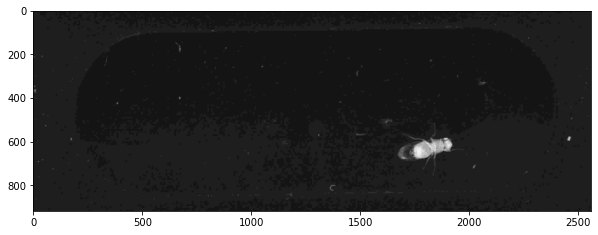

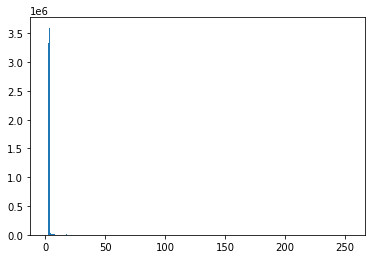

In [251]:
p = pd.read_csv('./data/Substack-StraightWalk-1_1.csv')
print(get_frame_x_y(p, 0)[0].shape)

plt.figure(figsize=(10,10))
img = plt.imread('./data/frames/001.jpg')
plt.imshow(img*10, cmap='gray')

plt.figure()
plt.hist(img.flatten(), bins=np.arange(0,255))

print(img.shape)

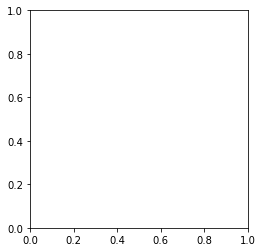

In [148]:
# save unaligned 
n_frames = 135
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=10)
with writer.saving(plt.figure(), "test.mp4", 100):
    for frame_idx in range(0, n_frames):
        img = read_image(frame_idx)
        x, y = get_frame_x_y(read_csv(), frame_idx)
        img_cropped, x_cropped, y_cropped = get_img_cropped(img, x, y)

        plt.imshow(img_cropped, cmap='gray')
        plt.scatter(x_cropped, y_cropped, c='red')

        for i in range(x_cropped.shape[0]):
            plt.annotate(f'{i}', (x_cropped[i], y_cropped[i]))

        plt.gca().axis('off')
        writer.grab_frame()
        plt.cla()

59.90391136271339


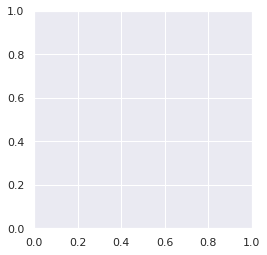

In [316]:
n_frames = 135
n_points = 4*6
leg_indices = [23,24,25,26,  15,16,17,18, 7,8,9,10,  19,20,21,22,  11,12,13,14,  3,4,5,6]
corr = [(23,0), (15,4), (7, 8), (19,12), (11, 16), (3,20)]
points2d = np.zeros((n_frames, n_points, 2))
p = read_csv()

#with writer.saving(plt.figure(), "test.mp4", 100):
for frame_idx in range(0, n_frames):
    x, y = get_frame_x_y(p, frame_idx)

    for src, dst in corr:
        points2d[frame_idx,dst:dst+4, 0] = x[src:src+4]
        points2d[frame_idx,dst:dst+4, 1] = y[src:src+4]

deg_list = list()
bb_list = list()
for frame_idx in range(0, n_frames):
    x, y = points2d[frame_idx, : ,0], points2d[frame_idx, : ,1]
    img_cropped, x_cropped, y_cropped, bb = get_img_cropped(read_image(frame_idx), x, y, None)
    bb_list.append(bb)

    x_sel = x_cropped[[c[1] for c in corr]]
    y_sel = y_cropped[[c[1] for c in corr]]

    coef_l = np.polyfit(x_sel[:3],y_sel[:3],1)
    deg_l = np.rad2deg(np.arctan(coef_l[0]))
    coef_r = np.polyfit(x_sel[3:],y_sel[3:],1)
    deg_r = np.rad2deg(np.arctan(coef_r[0]))

    deg =  (deg_l + deg_r) / 2 
    deg = deg - 180
    deg_list.append(deg)
    x_cropped, y_cropped = rotate(200, 200, x_cropped, y_cropped, -np.deg2rad(deg))
    points2d[frame_idx, :, 0] = x_cropped
    points2d[frame_idx, :, 1] = y_cropped

        
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=10)
with writer.saving(plt.figure(), "test.mp4", 100):
    for frame_idx in range(0, n_frames):
        img_cropped, x_cropped, y_cropped, _ = get_img_cropped(read_image(frame_idx), None, None, bb_list[frame_idx])
        
        x, y = points2d[frame_idx, :, 0], points2d[frame_idx, :, 1]
        plt.imshow(ndimage.rotate(img_cropped, deg_list[frame_idx], reshape=False), cmap='gray')
        plt.scatter(x, y, c='red')
        for i in range(x.shape[0]):
            plt.annotate(f'{i}', (x[i], y[i]))
        writer.grab_frame()
        plt.cla()
        
points2d -= points2d.mean(axis=0, keepdims=True).mean(axis=1, keepdims=True)
points2d /= 3
points2d += p_opt.mean(axis=0,keepdims=True).mean(axis=1, keepdims=True)

print(np.mean(points2d))
            
pickle.dump({"points2d": points2d, "bb":bb_list, "deg":deg_list}, open('/data/LiftFly3D/flylimbtracker/network/flylimbtracker.pkl', 'wb'))

In [286]:
from IPython.display import Video
Video('test.mp4', embed=True)

In [ ]:
f= plt.figure(figsize=(10,10))
im_rot = ndimage.rotate(imgs[200],90)
plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
plot_skeleton(poses[200,:,0],poses[200,:,1], ids, color_edge)

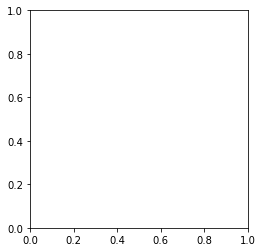

In [130]:
n_frames = 135
n_points = 38
points2d = pickle.load(open('flylimbtracker.pkl', 'rb'))["points2d"]

FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=10)
with writer.saving(plt.figure(), "test.mp4", 100):
    for frame_idx in range(0, 1):
        img = read_image(frame_idx)
        x, y = points2d[frame_idx][:, 0], points2d[frame_idx][:, 1]
        x = x[x!=0]
        y = y[y!=0]
        img_cropped, x_cropped, y_cropped = get_img_cropped(img, x, y)
        
        '''
        x_sel = x_cropped[[0, 4, 8, 12, 16 ,20], [0]]
        y_sel = x_cropped[[0, 4, 8, 12, 16 ,20], [1]]
        ang = -1 * np.rad2deg(np.arctan(np.polyfit(x_sel, y_sel, 1)[0]))

        x = x[x!=0]
        y = y[y!=0]
        
        #print(x,y)aak
        

        x_cropped, y_cropped = rotate(0,0, x_cropped,y_cropped, -1 * np.deg2rad(ang))
        '''
        plt.imshow(img_cropped, cmap='gray')
        plt.scatter(x_cropped, y_cropped, c='red')

        for i in range(x_cropped.shape[0]):
            plt.annotate(f'{i}', (x_cropped[i], y_cropped[i]))

        #plt.gca().axis('off')
        writer.grab_frame()
        plt.cla()

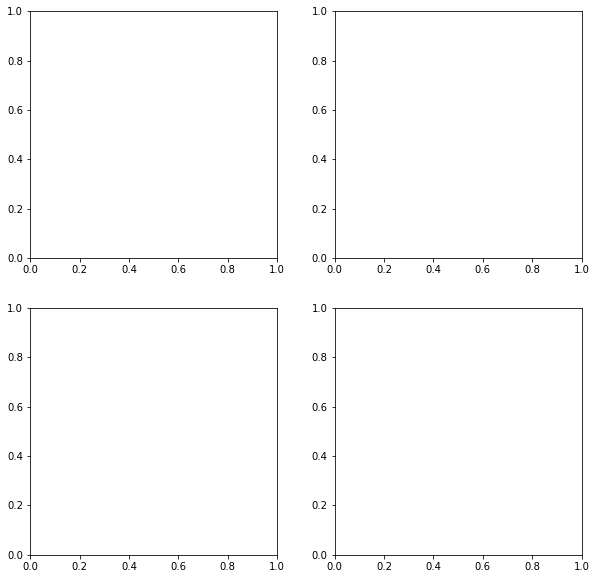

In [204]:
from scipy import ndimage

fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.flatten()
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=10)

with writer.saving(fig, "test.mp4", 100):
    for frame_idx in range(n_frames):
        img = read_image(frame_idx)

        x, y = points2d[frame_idx][:, 0], points2d[frame_idx][:, 1]
        x = x[x!=0]
        y = y[y!=0]
        img_cropped, x_cropped, y_cropped = get_img_cropped(img, x, y)
        #plt.figure()
        axs[0].imshow(img_cropped, cmap='gray')
        axs[0].scatter(x_cropped, y_cropped, c='red')
        for i in range(x_cropped.shape[0]):
            axs[0].annotate(f'{i}', (x_cropped[i], y_cropped[i]))

        #plt.figure()
        x_sel = x_cropped[[0, 4, 8, 12, 16 ,20]]
        y_sel = y_cropped[[0, 4, 8, 12, 16 ,20]]
        axs[1].imshow(img_cropped, cmap='gray')
        axs[1].scatter(x_sel, y_sel, c='red')
        for i in range(x_sel.shape[0]):
            axs[1].annotate(f'{i}', (x_sel[i], y_sel[i]))

        #plt.figure()
        coef_l = np.polyfit(x_sel[:3],y_sel[:3],1)
        deg_l = np.rad2deg(np.arctan(coef_l[0]))
        coef_r = np.polyfit(x_sel[3:],y_sel[3:],1)
        deg_r = np.rad2deg(np.arctan(coef_r[0]))

        axs[1].imshow(img_cropped, cmap='gray')
        axs[1].plot(x_sel, y_sel, 'yo', x_sel, np.poly1d(coef_l)(x_sel), '--k')
        axs[1].plot(x_sel, y_sel, 'yo', x_sel, np.poly1d(coef_r)(x_sel), '--k')
        axs[1].plot(x_sel, y_sel, 'yo', x_sel, np.poly1d([(coef_l[0]+coef_r[0])/2, (coef_l[1]+coef_r[1])/2])(x_sel), '--k')

        #plt.figure()
        deg =  (deg_l + deg_r) / 2 
        deg = deg - 180
        #print(deg_l, deg_r, deg)
        x_cropped, y_cropped = rotate(200, 200, x_cropped, y_cropped, -np.deg2rad(deg))
        axs[2].imshow(ndimage.rotate(img_cropped, deg, reshape=False), cmap='gray')
        axs[2].scatter(x_cropped, y_cropped, c='red')

        x_cropped = x_cropped[[0, 4, 8, 12, 16 ,20]]
        y_cropped = y_cropped[[0, 4, 8, 12, 16 ,20]]

        coef_l = np.polyfit(x_cropped[:3],y_cropped[:3],1)
        deg_l = np.rad2deg(np.arctan(coef_l[0]))
        coef_r = np.polyfit(x_cropped[3:],y_cropped[3:],1)
        deg_r = np.rad2deg(np.arctan(coef_r[0]))

        axs[3].imshow(ndimage.rotate(img_cropped, deg, reshape=False), cmap='gray')

        axs[3].plot(x_cropped, y_cropped, 'yo', np.arange(100,300), np.poly1d(coef_l)(np.arange(100,300)), '--k')
        axs[3].plot(x_cropped, y_cropped, 'yo', np.arange(100,300), np.poly1d(coef_r)(np.arange(100,300)), '--k')
        axs[3].plot(x_cropped, y_cropped, 'yo', np.arange(100,300), np.poly1d([(coef_l[0]+coef_r[0])/2, (coef_l[1]+coef_r[1])/2])(np.arange(100,300)), '--k')
        
        writer.grab_frame()
        
        for ax in axs:
            ax.clear()

/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/user/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


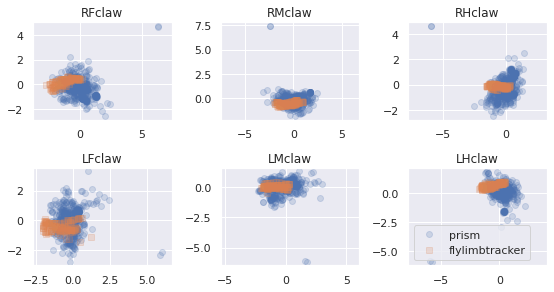

In [323]:
def unNormalizeData(data, data_mean, data_std):
    """
    Un-normalizes a matrix whose mean has been substracted and that has been divided by
    standard deviation. Some dimensions might also be missing
    """
    data *= data_std
    data += data_mean
    
    return data

tint = [0,135]
times = np.arange(tint[0],tint[1])

prism_dir = '/data/LiftFly3D/optobot/network/'
#optobot_dir = '/data/LiftFly3D/optobot/102906_s1a5_p6-0/'
optobot_dir = "/data/LiftFly3D/flylimbtracker/network/"

poses_optobot = torch.load(optobot_dir + 'test_2d.pth.tar')
poses_prism = torch.load(prism_dir + 'train_2d.pth.tar')

poses_optobot = np.vstack(poses_optobot.values())
poses_prism = np.vstack(poses_prism.values())

targets_1d = torch.load(optobot_dir + '/stat_2d.pth.tar')['targets_1d'] 
#targets_2d = torch.load(prism_dir + '/stat_2d.pth.tar')['targets_2d']   
#mean = torch.load(optobot_dir + '/stat_2d.pth.tar')['mean']
#std = torch.load(optobot_dir + '/stat_2d.pth.tar')['std']
#poses_optobot = unNormalizeData(poses_optobot, mean[targets_2d], std[targets_2d])
#poses_prism = unNormalizeData(poses_prism, mean[targets_2d], std[targets_2d])

poses_optobot = np.stack((poses_optobot[:,::2], poses_optobot[:,1::2]), axis=2)
poses_prism = np.stack((poses_prism[:,::2], poses_prism[:,1::2]), axis=2)

fig = plt.figure(figsize=([8,8])) 

joint_id = [2, 5, 8, 11, 14, 17] #legtips
#joint_id = [1, 2, 4,5, 7,8, 10,11, 13,14, 16,17]
for i, k in enumerate(joint_id):
    fig.add_subplot(4,3,i+1)
    plt.title(joints[targets_1d[k]])
    
    #for i in [2, 5, 8, 11, 14, 17]:#[4,9,14,19,24,29]:
    plt.plot(poses_prism[range(700),k,0], poses_prism[range(700),k,1],'o',alpha=0.2, label='prism')
    
    #for i in :#[3,7,11,15,19,23]:
    
    plt.plot(poses_optobot[times,k,0], poses_optobot[times,k,1],'s',alpha=0.2, label='flylimbtracker')
    plt.axis('equal')

plt.legend()
plt.tight_layout()
#plt.savefig('pose_distributions.png')

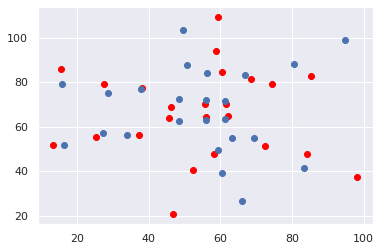

In [317]:
p_opt = pickle.load(open('optobot.pkl', 'rb'))["points2d"]
p_flt = pickle.load(open('/data/LiftFly3D/flylimbtracker/network/flylimbtracker.pkl', 'rb'))["points2d"] 

#p_flt += p_opt.mean(axis=0,keepdims=True).mean(axis=1, keepdims=True)
#p_flt -= p_flt.mean(axis=0, keepdims=True).mean(axis=1, keepdims=True)
#p_flt /= 3

f = 50
plt.scatter(p_opt[f,:,0], p_opt[f,:,1], c='red')
plt.scatter(p_flt[f,:,0], p_flt[f,:,1])
#plt.xlim([-50,50])
#plt.ylim([-50,50])

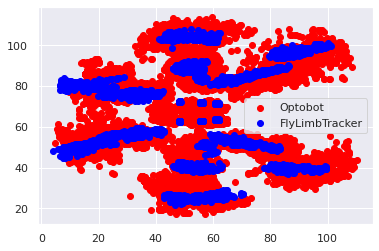

In [319]:
plt.scatter(p_opt[:,:,0], p_opt[:,:,1], c='red', label='Optobot')
plt.scatter(p_flt[:, :,0], p_flt[:,:,1], c='blue', label='FlyLimbTracker')
plt.legend()

ValueError: too many values to unpack (expected 2)

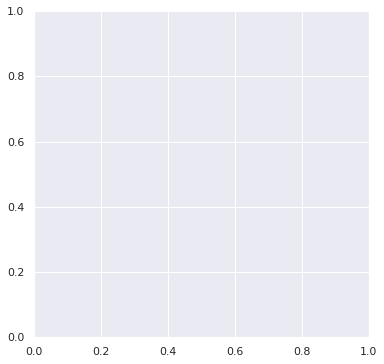

In [276]:
import seaborn as sns
sns.set()

x = p_opt[:,:,0]
y = p_opt[:,:,1]

f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(x, y, ax=ax)
sns.rugplot(x, color="g", ax=ax)
sns.rugplot(y, vertical=True, ax=ax);